# Sudoku miniproject

Below you will find the most elegant solution of sudoku solver coded by Peter Norvig. It's a good notation and implementation of two (simple) techniques that are enough to solve sudoku in a reasonable time.

You can find the original post here: http://norvig.com/sudoku.html

The best website about sudoku: http://www.sudokudragon.com/sudokutheory.htm

### Sudoku Notation and Preliminary Notions

First we have to agree on some notation. A Sudoku puzzle is a grid of 81 squares; the majority of enthusiasts label the columns 1-9, the rows A-I, and call a collection of nine squares (column, row, or box) a unit and the squares that share a unit the peers. A puzzle leaves some squares blank and fills others with digits, and the whole idea is:
A puzzle is solved if the squares in each unit are filled with a permutation of the digits 1 to 9.
That is, no digit can appear twice in a unit, and every digit must appear once. This implies that each square must have a different value from any of its peers. Here are the names of the squares, a typical puzzle, and the solution to the puzzle:

```
 A1 A2 A3| A4 A5 A6| A7 A8 A9    4 . . |. . . |8 . 5     4 1 7 |3 6 9 |8 2 5 
 B1 B2 B3| B4 B5 B6| B7 B8 B9    . 3 . |. . . |. . .     6 3 2 |1 5 8 |9 4 7
 C1 C2 C3| C4 C5 C6| C7 C8 C9    . . . |7 . . |. . .     9 5 8 |7 2 4 |3 1 6 
---------+---------+---------    ------+------+------    ------+------+------
 D1 D2 D3| D4 D5 D6| D7 D8 D9    . 2 . |. . . |. 6 .     8 2 5 |4 3 7 |1 6 9 
 E1 E2 E3| E4 E5 E6| E7 E8 E9    . . . |. 8 . |4 . .     7 9 1 |5 8 6 |4 3 2 
 F1 F2 F3| F4 F5 F6| F7 F8 F9    . . . |. 1 . |. . .     3 4 6 |9 1 2 |7 5 8 
---------+---------+---------    ------+------+------    ------+------+------
 G1 G2 G3| G4 G5 G6| G7 G8 G9    . . . |6 . 3 |. 7 .     2 8 9 |6 4 3 |5 7 1 
 H1 H2 H3| H4 H5 H6| H7 H8 H9    5 . . |2 . . |. . .     5 7 3 |2 9 1 |6 8 4 
 I1 I2 I3| I4 I5 I6| I7 I8 I9    1 . 4 |. . . |. . .     1 6 4 |8 7 5 |2 9 3 
```

Every square has exactly 3 units and 20 peers. For example, here are the units and peers for the square C2:

```
    A2   |         |                    |         |            A1 A2 A3|         |         
    B2   |         |                    |         |            B1 B2 B3|         |         
    C2   |         |            C1 C2 C3| C4 C5 C6| C7 C8 C9   C1 C2 C3|         |         
---------+---------+---------  ---------+---------+---------  ---------+---------+---------
    D2   |         |                    |         |                    |         |         
    E2   |         |                    |         |                    |         |         
    F2   |         |                    |         |                    |         |         
---------+---------+---------  ---------+---------+---------  ---------+---------+---------
    G2   |         |                    |         |                    |         |         
    H2   |         |                    |         |                    |         |         
    I2   |         |                    |         |                    |         |    
```

In [1]:
#notation
def cross(A, B):
    "Cross product of elements in A and elements in B."
    return [a+b for a in A for b in B]

digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)

unitlist = ([cross(rows, c) for c in cols] +
            [cross(r, cols) for r in rows] +
            [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u]) 
             for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s]))
             for s in squares)

print(units['A1'])
print(peers['A1'])

[['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9'], ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']]
{'E1', 'B1', 'G1', 'A9', 'C2', 'A7', 'A2', 'A5', 'F1', 'B3', 'B2', 'A6', 'H1', 'D1', 'C1', 'A3', 'A4', 'A8', 'C3', 'I1'}


### Sudoku grid
Now that we have squares, units, and peers, the next step is to define the Sudoku playing grid. Actually we need two representations: First, a textual format used to specify the initial state of a puzzle; we will reserve the name grid for this. Second, an internal representation of any state of a puzzle, partially solved or complete; this we will call a values collection because it will give all the remaining possible values for each square. For the textual format (grid) we'll allow a string of characters with 1-9 indicating a digit, and a 0 or period specifying an empty square. All other characters are ignored (including spaces, newlines, dashes, and bars). So each of the following three grid strings represent the same puzzle:



#### Sample sudoku grids

In [2]:
grid_solvable = '003020600900305001001806400008102900700000008006708200002609500800203009005010300'
grid_notsolvable = '4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
grid_naked = '509020010400056000800903005087002500654000082001568497108205000700680003040070800'

In [3]:
# parser
def grid_values(grid):
    "Convert grid into a dict of {square: char} with '0' or '.' for empties."
    grid = grid.replace('0', '.')
    chars = [c for c in grid if c in digits or c in '.']
    assert len(chars) == 81
    return dict(zip(squares, chars))

def display(values, title = ''):
    "Display these values as a 2-D grid."
    if title:
        print(title,':')
    if not values:
        print('Failed to solve, contradiction occurred')
        return
    width = 1+max(len(values[s]) for s in squares)
    line = '+'.join(['-'*(width*3)]*3)
    for r in rows:
        print(''.join(values[r+c].center(width)+('|' if c in '36' else '') for c in cols))
        if r in 'CF': print(line)
    print()

# sample sudoku
display(grid_values(grid_solvable), 'Solvable')
display(grid_values(grid_notsolvable), 'Notsolvable (by assign/eliminate)')
display(grid_values(grid_naked), 'Naked twin')

Solvable :
. . 3 |. 2 . |6 . . 
9 . . |3 . 5 |. . 1 
. . 1 |8 . 6 |4 . . 
------+------+------
. . 8 |1 . 2 |9 . . 
7 . . |. . . |. . 8 
. . 6 |7 . 8 |2 . . 
------+------+------
. . 2 |6 . 9 |5 . . 
8 . . |2 . 3 |. . 9 
. . 5 |. 1 . |3 . . 

Notsolvable (by assign/eliminate) :
4 . . |. . . |8 . 5 
. 3 . |. . . |. . . 
. . . |7 . . |. . . 
------+------+------
. 2 . |. . . |. 6 . 
. . . |. 8 . |4 . . 
. . . |. 1 . |. . . 
------+------+------
. . . |6 . 3 |. 7 . 
5 . . |2 . . |. . . 
1 . 4 |. . . |. . . 

Naked twin :
5 . 9 |. 2 . |. 1 . 
4 . . |. 5 6 |. . . 
8 . . |9 . 3 |. . 5 
------+------+------
. 8 7 |. . 2 |5 . . 
6 5 4 |. . . |. 8 2 
. . 1 |5 6 8 |4 9 7 
------+------+------
1 . 8 |2 . 5 |. . . 
7 . . |6 8 . |. . 3 
. 4 . |. 7 . |8 . . 



In [4]:
def is_solved(values):
    return all(len(d) == 1 for d in values.values())

def is_failed(values):
    empties =  any(len(d) == 0 for d in values.values()) 
    if empties:
        return True
#     display(values, 'Check')
    for unit in unitlist:
        vals = [values[s] for s in unit]
        if all(len(d) == 1 for d in vals) and len(vals) != len(set(vals)):
#             print(unit, vals)
            return True
    return False
    

### Parser
Now for values. One might think that a 9 x 9 array would be the obvious data structure. But squares have names like 'A1', not (0,0). Therefore, values will be a dict with squares as keys. The value of each key will be the possible digits for that square: a single digit if it was given as part of the puzzle definition or if we have figured out what it must be, and a collection of several digits if we are still uncertain. This collection of digits could be represented by a Python set or list, but I chose instead to use a string of digits (we'll see why later). So a grid where A1 is 7 and C7 is empty would be represented as {'A1': '7', 'C7': '123456789', ...}.

In [5]:
def solve_orginal(grid):
    """Convert grid to a dict of possible values, {square: digits}, or
    return False if a contradiction is detected."""
    ## To start, every square can be any digit; then assign values from the grid.
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits and not orginal_assign(values, s, d):
            return False ## (Fail if we can't assign d to square s.)
    return values

# Constraint Propagation - original code
The function parse_grid calls assign(values, s, d). We could implement this as values[s] = d, but we can do more than just that. Those with experience solving Sudoku puzzles know that there are two important strategies that we can use to make progress towards filling in all the squares:

(1) If a square has only one possible value, then eliminate that value from the square's peers. 

(2) If a unit has only one possible place for a value, then put the value there.

As an example of strategy (1) if we assign 7 to A1, yielding {'A1': '7', 'A2':'123456789', ...}, we see that A1 has only one value, and thus the 7 can be removed from its peer A2 (and all other peers), giving us {'A1': '7', 'A2': '12345689', ...}. As an example of strategy (2), if it turns out that none of A3 through A9 has a 3 as a possible value, then the 3 must belong in A2, and we can update to {'A1': '7', 'A2':'3', ...}. These updates to A2 may in turn cause further updates to its peers, and the peers of those peers, and so on. This process is called constraint propagation.

The function assign(values, s, d) will return the updated values (including the updates from constraint propagation), but if there is a contradiction--if the assignment cannot be made consistently--then assign returns False. For example, if a grid starts with the digits '77...' then when we try to assign the 7 to A2, assign would notice that 7 is not a possibility for A2, because it was eliminated by the peer, A1.

It turns out that the fundamental operation is not assigning a value, but rather eliminating one of the possible values for a square, which we implement with eliminate(values, s, d). Once we have eliminate, then assign(values, s, d) can be defined as "eliminate all the values from s except d".

In [6]:
def orginal_assign(values, s, d):
    """Eliminate all the other values (except d) from values[s] and propagate.
    Return values, except return False if a contradiction is detected."""
    other_values = values[s].replace(d, '')
    if all(orginal_eliminate(values, s, d2) for d2 in other_values):
        return values
    else:
        return False

def orginal_eliminate(values, s, d):
    """Eliminate d from values[s]; propagate when values or places <= 2.
    Return values, except return False if a contradiction is detected."""
    if d not in values[s]:
        return values ## Already eliminated
    values[s] = values[s].replace(d,'')
    ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
    if len(values[s]) == 0:
        return False ## Contradiction: removed last value
    elif len(values[s]) == 1:
        d2 = values[s]
        if not all(orginal_eliminate(values, s2, d2) for s2 in peers[s]):
            return False
    ## (2) If a unit u is reduced to only one place for a value d, then put it there.
    for u in units[s]:
        dplaces = [s for s in u if d in values[s]]
        if len(dplaces) == 0:
            return False ## Contradiction: no place for this val
        elif len(dplaces) == 1:
            # d can only be in one place in unit; assign it there
            if not orginal_assign(values, dplaces[0], d):
                return False
    return values

### Test run on orginal code

In [7]:
display(solve_orginal(grid_solvable), 'Solvable, orginal')
display(solve_orginal(grid_notsolvable), 'Unsolvable, orginal')
display(solve_orginal(grid_naked), 'Naked twin, orginal')

Solvable, orginal :
4 8 3 |9 2 1 |6 5 7 
9 6 7 |3 4 5 |8 2 1 
2 5 1 |8 7 6 |4 9 3 
------+------+------
5 4 8 |1 3 2 |9 7 6 
7 2 9 |5 6 4 |1 3 8 
1 3 6 |7 9 8 |2 4 5 
------+------+------
3 7 2 |6 8 9 |5 1 4 
8 1 4 |2 5 3 |7 6 9 
6 9 5 |4 1 7 |3 8 2 

Unsolvable, orginal :
   4      1679   12679  |  139     2369    269   |   8      1239     5    
 26789     3    1256789 | 14589   24569   245689 | 12679    1249   124679 
  2689   15689   125689 |   7     234569  245689 | 12369   12349   123469 
------------------------+------------------------+------------------------
  3789     2     15789  |  3459   34579    4579  | 13579     6     13789  
  3679   15679   15679  |  359      8     25679  |   4     12359   12379  
 36789     4     56789  |  359      1     25679  | 23579   23589   23789  
------------------------+------------------------+------------------------
  289      89     289   |   6      459      3    |  1259     7     12489  
   5      6789     3    |   2      479      1    | 

# Constraint Propagation - code refactoring

Try to decompose* eliminate function into smaller one.
* Decomposition is a process by which you can break down one complex function into multiple smaller functions. By doing this, you can solve for functions in shorter, easier-to-understand pieces.

In [8]:
def eliminate(values):
    """
    Iterate through all squares and every time 
       if there is a square with one value, 
       then eliminate this value from the peers

    input: sudoku in dictionary form
    output: resulting sudoku in dictionary form
    """
    for s, d in values.items():
        if len(d) != 1:
            continue
        for s_peer in peers[s]:
            values[s_peer] = values[s_peer].replace(d,'')
            
    return values


def only_choice(values):
    """
    Iterate through all squares and every time
        if there is a square with a value that only fits in one square, 
        assign the value to this square

    input: sudoku in dictionary form
    output: resulting sudoku in dictionary form
    """
    for s, d in values.items():
        for u in units[s]:
            other_s_in_units = set(u)-{s}
            values_in_other = {d2 for s2 in other_s_in_units for d2 in values[s2]}
            possible_in_s = list(set(d)-values_in_other)
            if len(possible_in_s) == 1 and possible_in_s[0] != d :
                values[s] = possible_in_s[0]

    return values


def reduce_puzzle(values, use_naked_twins):
    """
    Solve sudoku using eliminate() and only_choice()
    
    input: sudoku in dictionary form
    output: resulting sudoku in dictionary form
    """
    changed = True
    while changed:
        new_values = eliminate(values.copy())
        new_values = only_choice(new_values)
        if use_naked_twins:
            new_values = naked_twins(new_values)
        changed = new_values != values
        values = new_values
        if is_failed(values):
            # found contradiction
            return False
    return values

def solve_refactored(grid):
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits:
            values[s] = d
    return reduce_puzzle(values, False)       

### Test run on refactored code

In [9]:
display(solve_refactored(grid_solvable), 'Solvable, refactored')
display(solve_refactored(grid_notsolvable), 'Unsolvable, refactored')
display(solve_refactored(grid_naked), 'Naked twin, refactored')

Solvable, refactored :
4 8 3 |9 2 1 |6 5 7 
9 6 7 |3 4 5 |8 2 1 
2 5 1 |8 7 6 |4 9 3 
------+------+------
5 4 8 |1 3 2 |9 7 6 
7 2 9 |5 6 4 |1 3 8 
1 3 6 |7 9 8 |2 4 5 
------+------+------
3 7 2 |6 8 9 |5 1 4 
8 1 4 |2 5 3 |7 6 9 
6 9 5 |4 1 7 |3 8 2 

Unsolvable, refactored :
   4      1679   12679  |  139     2369    269   |   8      1239     5    
 26789     3    1256789 | 14589   24569   245689 | 12679    1249   124679 
  2689   15689   125689 |   7     234569  245689 | 12369   12349   123469 
------------------------+------------------------+------------------------
  3789     2     15789  |  3459   34579    4579  | 13579     6     13789  
  3679   15679   15679  |  359      8     25679  |   4     12359   12379  
 36789     4     56789  |  359      1     25679  | 23579   23589   23789  
------------------------+------------------------+------------------------
  289      89     289   |   6      459      3    |  1259     7     12489  
   5      6789     3    |   2      479      1

# Naked twins
http://www.sudokudragon.com/tutorialnakedtwins.htm


In [10]:
def naked_twins(values):
    """
    Eliminate values using the naked twins strategy
    
    input: A sudoku in dictionary form.
    output: The resulting sudoku in dictionary form.
    """
    twin_values_squares = { s: d for s, d in values.items() if len(d) == 2}
    twin_combinations = ( (x,y) for x in twin_values_squares for y in twin_values_squares 
                         if twin_values_squares[x] == twin_values_squares[y] and x < y)
    
    # check if elements in twin_combinations are in the same unit
    for s1, s2 in twin_combinations:
        # note, may be more then 1 matching unit, eg A1+A2 are in two
        matching_units = [unit for unit in unitlist if s1 in unit and s2 in unit]
        for matching_unit in matching_units:
            twins = twin_values_squares[s1]
#             print('Found twins:', s1, s2, twins)
            #remove other values then 'twins' in other fields
            for s in [a for a in matching_unit if a not in {s1, s2}]:
                values[s] = values[s].replace(twins[0], '')
                values[s] = values[s].replace(twins[1], '')

    return values

In [11]:
def solve_refactored_naked(grid):
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits:
            values[s] = d
    return reduce_puzzle(values, True) 

### Test run on refactored code with naked twins

In [12]:
display(solve_refactored_naked(grid_solvable), 'Solvable, refactored+naked_twins')
display(solve_refactored_naked(grid_notsolvable), 'Unsolvable, refactored+naked_twins')
display(solve_refactored_naked(grid_naked), 'Naked twin, refactored+naked_twins')

Solvable, refactored+naked_twins :
4 8 3 |9 2 1 |6 5 7 
9 6 7 |3 4 5 |8 2 1 
2 5 1 |8 7 6 |4 9 3 
------+------+------
5 4 8 |1 3 2 |9 7 6 
7 2 9 |5 6 4 |1 3 8 
1 3 6 |7 9 8 |2 4 5 
------+------+------
3 7 2 |6 8 9 |5 1 4 
8 1 4 |2 5 3 |7 6 9 
6 9 5 |4 1 7 |3 8 2 

Unsolvable, refactored+naked_twins :
   4      1679   12679  |  139     2369    269   |   8      1239     5    
 26789     3    1256789 | 14589   24569   245689 | 12679    1249   124679 
  2689   15689   125689 |   7     234569  245689 | 12369   12349   123469 
------------------------+------------------------+------------------------
  3789     2     15789  |  3459   34579    4579  | 13579     6     13789  
  3679   15679   15679  |  359      8     25679  |   4     12359   12379  
 36789     4     56789  |  359      1     25679  | 23579   23589   23789  
------------------------+------------------------+------------------------
  289      89     289   |   6      459      3    |  1259     7     12489  
   5      6789     3 

# Graph serach (DFS)

In [13]:
def reduce_graph(values):
    values = reduce_puzzle(values, True) 
#     display(values)
    # base cases first
    if not values:
        return False
    if is_solved(values):
        return values    
    
    # get unfilled square with minimum possible choices
    minchoices = min([s for s, d in values.items() if len(d) > 1], key=lambda x: len(values[x]))
    for choice_val in values[minchoices]:
#         print('Set', minchoices, 'to', choice_val)
        new_values = values.copy()
        new_values[minchoices] = choice_val
        new_values = reduce_graph(new_values)
        if new_values:
            return new_values
#         print('Revert', minchoices, 'to', choice_val)
    return False

def solve_graph(grid):
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits:
            values[s] = d
    return reduce_graph(values)

### Test run on graph searching

In [14]:
display(solve_graph(grid_solvable), 'Solvable, graph search')
display(solve_graph(grid_notsolvable), 'Unsolvable, graph search')
display(solve_graph(grid_naked), 'Naked twin, graph search')

Solvable, graph search :
4 8 3 |9 2 1 |6 5 7 
9 6 7 |3 4 5 |8 2 1 
2 5 1 |8 7 6 |4 9 3 
------+------+------
5 4 8 |1 3 2 |9 7 6 
7 2 9 |5 6 4 |1 3 8 
1 3 6 |7 9 8 |2 4 5 
------+------+------
3 7 2 |6 8 9 |5 1 4 
8 1 4 |2 5 3 |7 6 9 
6 9 5 |4 1 7 |3 8 2 

Unsolvable, graph search :
4 1 7 |3 6 9 |8 2 5 
6 3 2 |1 5 8 |9 4 7 
9 5 8 |7 2 4 |3 1 6 
------+------+------
8 2 5 |4 3 7 |1 6 9 
7 9 1 |5 8 6 |4 3 2 
3 4 6 |9 1 2 |7 5 8 
------+------+------
2 8 9 |6 4 3 |5 7 1 
5 7 3 |2 9 1 |6 8 4 
1 6 4 |8 7 5 |2 9 3 

Naked twin, graph search :
5 3 9 |4 2 7 |6 1 8 
4 1 2 |8 5 6 |7 3 9 
8 7 6 |9 1 3 |2 4 5 
------+------+------
9 8 7 |3 4 2 |5 6 1 
6 5 4 |7 9 1 |3 8 2 
3 2 1 |5 6 8 |4 9 7 
------+------+------
1 6 8 |2 3 5 |9 7 4 
7 9 5 |6 8 4 |1 2 3 
2 4 3 |1 7 9 |8 5 6 



# Analyze time performance

In [15]:
import urllib

# define utility function to read grids from web
def get_grids(url):
    response = urllib.request.urlopen(url)
    txt = response.read().decode('utf-8')
    lines = txt.split('\n')
    valid_lines = [l for l in lines if len(l) in {9,81}]
    valid_concat = ''.join(valid_lines)
    grids = [valid_concat[i:i+81] for i in range(0,len(valid_concat),81)]
    print('Get {} grids from {}'.format(len(grids), url))
    return grids

In [16]:
# get some grids
easy = get_grids('http://norvig.com/easy50.txt')
hard = get_grids('http://norvig.com/top95.txt')
hardest = get_grids('http://norvig.com/hardest.txt')
other = get_grids('https://projecteuler.net/project/resources/p096_sudoku.txt')
hardcore = ['005300000800000020070010500400005300010070006003200080060500009004000030000009700']


Get 50 grids from http://norvig.com/easy50.txt
Get 95 grids from http://norvig.com/top95.txt
Get 11 grids from http://norvig.com/hardest.txt
Get 50 grids from https://projecteuler.net/project/resources/p096_sudoku.txt


In [17]:
# validate grids
print(easy[:5])
print(hard[:5])
print(hardest[:5])
print(other[:5])
print(hardcore[:5])

assert(len(easy) == 50)
assert(len(hard) == 95)
assert(len(hardest) == 11)
assert(len(other) == 50)

assert(all(len(g) == 81 for g in easy))
assert(all(len(g) == 81 for g in hard))
assert(all(len(g) == 81 for g in hardest))
assert(all(len(g) == 81 for g in other))
assert(all(len(g) == 81 for g in hardcore))

['003020600900305001001806400008102900700000008006708200002609500800203009005010300', '200080300060070084030500209000105408000000000402706000301007040720040060004010003', '000000907000420180000705026100904000050000040000507009920108000034059000507000000', '030050040008010500460000012070502080000603000040109030250000098001020600080060020', '020810740700003100090002805009040087400208003160030200302700060005600008076051090']
['4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......', '52...6.........7.13...........4..8..6......5...........418.........3..2...87.....', '6.....8.3.4.7.................5.4.7.3..2.....1.6.......2.....5.....8.6......1....', '48.3............71.2.......7.5....6....2..8.............1.76...3.....4......5....', '....14....3....2...7..........9...3.6.1.............8.2.....1.4....5.6.....7.8...']
['85...24..72......9..4.........1.7..23.5...9...4...........8..7..17..........36.4.', '..53.....8......2..7..1.5..4....53...1..7...6..32...8..6.5...

In [18]:
# deifne function for timing grid, if grid is nonsolvable returns None
import time
def time_sudoku_solution(grid, solver):
    start = time.clock()
    solution = solver(grid)
    dt = time.clock()-start
    return dt if is_solved(solution) else None

In [19]:
#create dataframe with grids
import pandas as pd
sudoku_df = pd.DataFrame(columns=['grid', 'level'])

for grids, level in ((easy, 'easy'), (hard, 'hard'), (hardest, 'hardest'), (hardcore, 'hardcore'), (other, 'other')):
    for g in grids:
        sudoku_df = sudoku_df.append({'grid':g, 'level':level}, ignore_index=True)
sudoku_df.level = sudoku_df.level.astype('category')

In [20]:
sudoku_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 2 columns):
grid     207 non-null object
level    207 non-null category
dtypes: category(1), object(1)
memory usage: 28.6 KB


In [21]:
sudoku_df.shape

(207, 2)

In [22]:
# run different solvers
for solver, column in [(solve_orginal, 'time_original'), (solve_refactored, 'time_refactored'), (solve_refactored_naked, 'time_naked'), (solve_graph, 'time_graph')]:
    times = sudoku_df.grid.apply(time_sudoku_solution, args=(solver,))
    sudoku_df[column] = times # pd.to_timedelta(times, unit='s')
                                                                                                                                         

In [23]:
sudoku_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 6 columns):
grid               207 non-null object
level              207 non-null category
time_original      81 non-null float64
time_refactored    81 non-null float64
time_naked         89 non-null float64
time_graph         207 non-null float64
dtypes: category(1), float64(4), object(1)
memory usage: 35.1 KB


In [24]:
sudoku_df.head()

,grid,level,time_original,time_refactored,time_naked,time_graph
0,0030206009003050010018064000081029007000000080...,easy,0.003832,0.005945,0.006281,0.006193
1,2000803000600700840305002090001054080000000004...,easy,0.003898,0.006015,0.006200,0.006040
2,0000009070004201800007050261009040000500000400...,easy,0.003775,0.009281,0.010051,0.009691
3,0300500400080105004600000120705020800006030000...,easy,0.005208,0.005779,0.006161,0.006025
4,0208107407000031000900028050090400874002080031...,easy,0.003781,0.004740,0.004869,0.004869


In [26]:
%matplotlib inline

In [28]:
# Get some graphs
import seaborn as sns

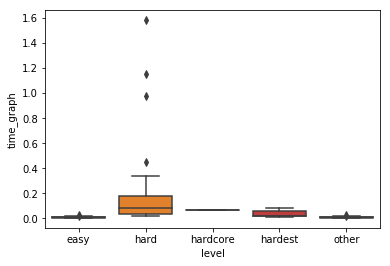

In [32]:
sns.boxplot(data=sudoku_df, y='time_graph', x='level')

In [30]:
g = sns.PairGrid(tips,
                 x_vars=["smoker", "time", "sex"],
                 y_vars=["total_bill", "tip"],
                 aspect=.75, size=3.5)
g.map(sns.violinplot, palette="pastel");

NameError: name 'tips' is not defined